In [1]:
from google.colab import drive
import os
import json
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

In [2]:
print("Mounting Google Drive...")
drive.mount('/content/drive')

Mounting Google Drive...
Mounted at /content/drive


In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ditogogua","key":"65a423eed3ea99d51a9c7348b802e85b"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle competitions list | head -5

ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2025                               2025-11-03 23:59:00  Featured         1,000,000 Usd        643           False  
https://www.kaggle.com/competitions/google-gemma-3n-hackathon                    2025-08-06 23:59:00  Featured           150,000 Usd          0           False  
https://www.kaggle.com/competitions/make-data-count-finding-data-references      2025-09-09 23:59:00  Research           100,000 Usd        575           False  


In [6]:
!kaggle competitions download -c walmart-recruiting-store-sales-forecasting

  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 224MB/s]


In [7]:
with zipfile.ZipFile('walmart-recruiting-store-sales-forecasting.zip', 'r') as zip_ref:
    zip_ref.extractall('walmart_data')

print("Extracted files:")
for root, dirs, files in os.walk('walmart_data'):
    for file in files:
        print(os.path.join(root, file))

Extracted files:
walmart_data/stores.csv
walmart_data/sampleSubmission.csv.zip
walmart_data/train.csv.zip
walmart_data/features.csv.zip
walmart_data/test.csv.zip


In [8]:
print("\nExtracting individual CSV files...")
csv_files = ['train.csv.zip', 'test.csv.zip', 'features.csv.zip', 'stores.csv', 'sampleSubmission.csv.zip']


Extracting individual CSV files...


In [9]:
for file in csv_files:
    file_path = os.path.join('walmart_data', file)
    if os.path.exists(file_path) and file.endswith('.zip'):
        print(f"Extracting {file}...")
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall('walmart_data')
    elif os.path.exists(file_path):
        print(f"{file} already extracted or not zipped")

Extracting train.csv.zip...
Extracting test.csv.zip...
Extracting features.csv.zip...
stores.csv already extracted or not zipped
Extracting sampleSubmission.csv.zip...


In [10]:
print("\nFinal extracted files:")
for root, dirs, files in os.walk('walmart_data'):
    for file in files:
        if file.endswith('.csv'):
            print(os.path.join(root, file))


Final extracted files:
walmart_data/train.csv
walmart_data/sampleSubmission.csv
walmart_data/stores.csv
walmart_data/test.csv
walmart_data/features.csv


In [11]:
import os
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")

def calculate_wmae(y_true, y_pred, weights=None):
    """
    Calculate Weighted Mean Absolute Error (WMAE)

    Args:
        y_true: True values
        y_pred: Predicted values
        weights: Weights for each sample (optional)

    Returns:
        WMAE value
    """
    if weights is None:
        weights = np.ones(len(y_true))

    wmae = np.sum(weights * np.abs(y_true - y_pred)) / np.sum(weights)
    return wmae


In [12]:
def create_advanced_features(df_input):
    """Create advanced time-based and lag features"""
    df_input['Year'] = df_input['Date'].dt.year
    df_input['Month'] = df_input['Date'].dt.month
    df_input['Week'] = df_input['Date'].dt.isocalendar().week.astype(int)
    df_input['Day'] = df_input['Date'].dt.day
    df_input['DayOfWeek'] = df_input['Date'].dt.dayofweek
    df_input['DayOfYear'] = df_input['Date'].dt.dayofyear

    df_input['Quarter'] = df_input['Date'].dt.quarter
    df_input['WeekOfYear'] = df_input['Date'].dt.isocalendar().week.astype(int)
    df_input['IsWeekend'] = df_input['DayOfWeek'].isin([5, 6]).astype(int)
    df_input['IsMonthStart'] = df_input['Date'].dt.is_month_start.astype(int)
    df_input['IsMonthEnd'] = df_input['Date'].dt.is_month_end.astype(int)

    df_input['IsHoliday'] = df_input['IsHoliday'].astype(int)

    df_input['Season'] = pd.cut(df_input['Month'], bins=[0, 3, 6, 9, 12], labels=[1, 2, 3, 4])
    df_input['Season'] = df_input['Season'].astype(int)

    df_input['WeekOfMonth'] = ((df_input['Day'] - 1) // 7) + 1

    df_input['DaysSinceYearStart'] = df_input['Date'].dt.dayofyear

    df_input['DaysUntilYearEnd'] = 365 - df_input['Date'].dt.dayofyear

    df_input['DaysFromMonthEnd'] = df_input['Date'].dt.days_in_month - df_input['Day']

    df_input['DaysFromMonthStart'] = df_input['Day'] - 1

    return df_input

In [13]:
def create_lag_features(df, group_cols, target_col, lags=[1, 2, 3, 4, 12]):
    """Create lag features for time series"""
    df_lagged = df.copy()

    for lag in lags:
        df_lagged[f'{target_col}_lag_{lag}'] = df.groupby(group_cols)[target_col].shift(lag)

    return df_lagged

In [14]:
def create_rolling_features(df, group_cols, target_col, windows=[2, 3, 4, 8]):
    """Create rolling window features"""
    df_rolling = df.copy()

    for window in windows:
        df_rolling[f'{target_col}_rolling_mean_{window}'] = df.groupby(group_cols)[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).mean()
        )
        df_rolling[f'{target_col}_rolling_std_{window}'] = df.groupby(group_cols)[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).std()
        )
        df_rolling[f'{target_col}_rolling_min_{window}'] = df.groupby(group_cols)[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).min()
        )
        df_rolling[f'{target_col}_rolling_max_{window}'] = df.groupby(group_cols)[target_col].transform(
            lambda x: x.rolling(window=window, min_periods=1).max()
        )

    return df_rolling

In [15]:
def preprocess_data(df_train, df_test, df_features, df_stores):
    """Preprocess data with advanced feature engineering"""

    df = df_train.merge(df_stores, on='Store', how='left')

    common_cols_to_drop = [
        'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
        'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
        'IsHoliday'
    ]
    cols_to_drop = [col for col in common_cols_to_drop if col in df.columns]
    if cols_to_drop:
        df = df.drop(columns=cols_to_drop)

    df = df.merge(df_features, on=['Store', 'Date'], how='left')

    numeric_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                   'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

    for col in numeric_cols:
        if col in df.columns:
            df[col] = df.groupby('Store')[col].fillna(method='ffill').fillna(method='bfill')
            df[col] = df[col].fillna(df[col].median())

    if 'IsHoliday' in df.columns:
        df['IsHoliday'] = df['IsHoliday'].astype(int)
    else:
        df['IsHoliday'] = 0

    df['Weekly_Sales'] = df['Weekly_Sales'].apply(lambda x: max(0, x))

    df = df.sort_values(['Store', 'Dept', 'Date'])

    df = create_advanced_features(df)

    df = create_lag_features(df, ['Store', 'Dept'], 'Weekly_Sales', lags=[1, 2, 3, 4, 12, 52])

    df = create_rolling_features(df, ['Store', 'Dept'], 'Weekly_Sales', windows=[2, 3, 4, 8, 12])

    df['Store_Dept_Mean'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform('mean')
    df['Store_Dept_Std'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform('std')
    df['Store_Dept_Min'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform('min')
    df['Store_Dept_Max'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform('max')

    df['Store_Mean'] = df.groupby('Store')['Weekly_Sales'].transform('mean')
    df['Store_Std'] = df.groupby('Store')['Weekly_Sales'].transform('std')

    df['Dept_Mean'] = df.groupby('Dept')['Weekly_Sales'].transform('mean')
    df['Dept_Std'] = df.groupby('Dept')['Weekly_Sales'].transform('std')

    df['Size_Temperature'] = df['Size'] * df['Temperature']
    df['Size_Fuel_Price'] = df['Size'] * df['Fuel_Price']
    df['Temperature_Fuel_Price'] = df['Temperature'] * df['Fuel_Price']

    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    df['MarkDown_Sum'] = df[markdown_cols].sum(axis=1)
    df['MarkDown_Mean'] = df[markdown_cols].mean(axis=1)
    df['MarkDown_Std'] = df[markdown_cols].std(axis=1)

    df = pd.get_dummies(df, columns=['Type'], prefix='Type', drop_first=True)

    return df

In [16]:
def prepare_test_data(df_test, df_features, df_stores, X_train_columns):
    """Prepare test data with same preprocessing as training data"""

    df_test_merged = df_test.merge(df_stores, on='Store', how='left')

    common_cols_to_drop = [
        'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
        'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
        'IsHoliday'
    ]
    cols_to_drop = [col for col in common_cols_to_drop if col in df_test_merged.columns]
    if cols_to_drop:
        df_test_merged = df_test_merged.drop(columns=cols_to_drop)

    df_test_final = df_test_merged.merge(df_features, on=['Store', 'Date'], how='left')

    numeric_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
                   'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    for col in numeric_cols:
        if col in df_test_final.columns:
            df_test_final[col] = df_test_final[col].fillna(df_test_final[col].median())

    if 'IsHoliday' in df_test_final.columns:
        df_test_final['IsHoliday'] = df_test_final['IsHoliday'].astype(int)
    else:
        df_test_final['IsHoliday'] = 0

    df_test_final = create_advanced_features(df_test_final)

    df_test_final['Size_Temperature'] = df_test_final['Size'] * df_test_final['Temperature']
    df_test_final['Size_Fuel_Price'] = df_test_final['Size'] * df_test_final['Fuel_Price']
    df_test_final['Temperature_Fuel_Price'] = df_test_final['Temperature'] * df_test_final['Fuel_Price']

    markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
    df_test_final['MarkDown_Sum'] = df_test_final[markdown_cols].sum(axis=1)
    df_test_final['MarkDown_Mean'] = df_test_final[markdown_cols].mean(axis=1)
    df_test_final['MarkDown_Std'] = df_test_final[markdown_cols].std(axis=1)

    if 'Type' in df_test_final.columns:
        df_test_final = pd.get_dummies(df_test_final, columns=['Type'], prefix='Type', drop_first=True)

    X_test = df_test_final.reindex(columns=X_train_columns, fill_value=0)

    if X_test.isnull().sum().sum() > 0:
        X_test = X_test.fillna(0)

    return X_test


Loading data...
All dataframes loaded successfully.
Preprocessing training data...
Final features: 72
Train set size: 294132
Validation set size: 127438
Training optimized LightGBM model...
[200]	valid_0's rmse: 11613
[400]	valid_0's rmse: 5106.51
[600]	valid_0's rmse: 1938.54
[800]	valid_0's rmse: 1191.74
[1000]	valid_0's rmse: 1072.14
[1200]	valid_0's rmse: 1020.26
[1400]	valid_0's rmse: 977.287
[1600]	valid_0's rmse: 944.532
[1800]	valid_0's rmse: 928.655
[2000]	valid_0's rmse: 922.012
[2200]	valid_0's rmse: 911.264
[2400]	valid_0's rmse: 900.263
[2600]	valid_0's rmse: 892.623
[2800]	valid_0's rmse: 888.853
[3000]	valid_0's rmse: 884.495
Actual sales range: 0.00 to 233140.32
Predicted sales range: -67.34 to 192924.87
Number of holiday weeks: 5967
Total validation samples: 127438
Weighted errors sum: 29658550.96
Weights sum: 151306
Manual WMAE: 196.02
Function WMAE: 196.02

Validation Metrics:
RMSE: 884.49
MAE: 186.35
WMAE: 196.02
Best iteration: 2998

Top 10 Most Important Features:

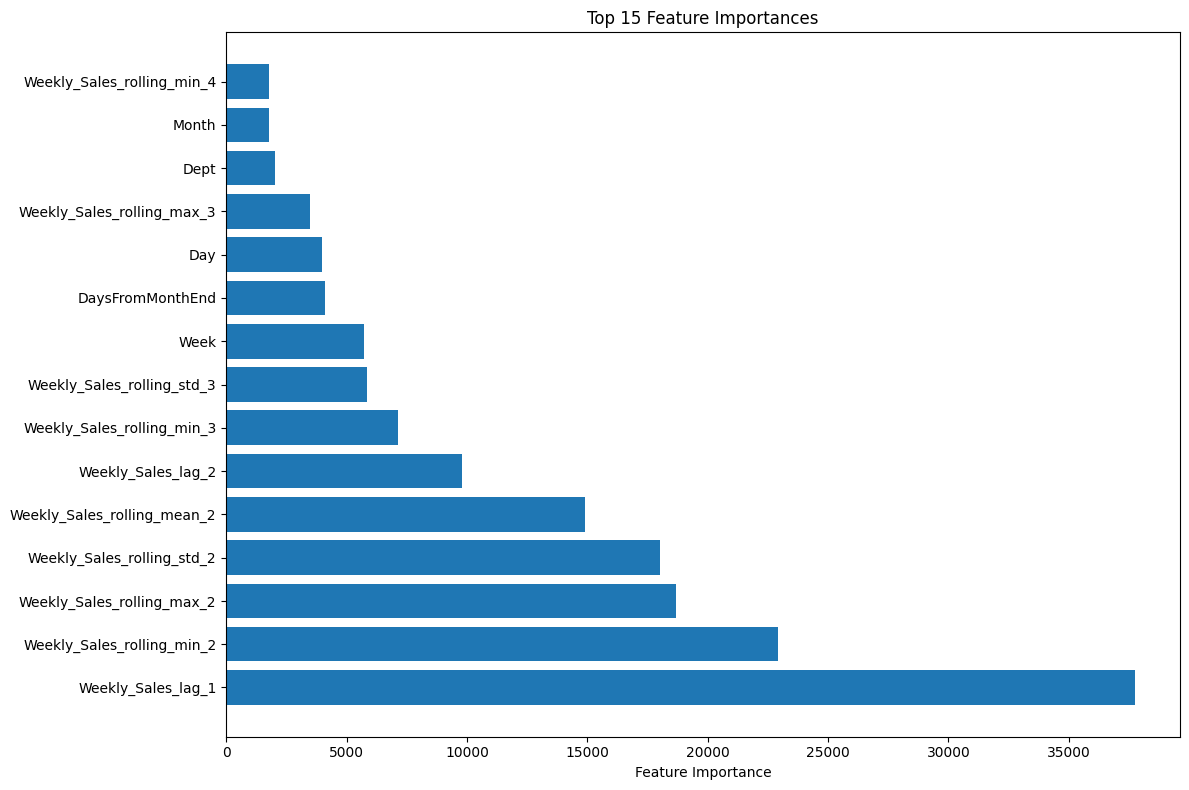

In [17]:
def main():
    print("Loading data...")
    data_base_path = 'walmart_data/'

    try:
        df_train = pd.read_csv(f'{data_base_path}train.csv', parse_dates=['Date'])
        df_test = pd.read_csv(f'{data_base_path}test.csv', parse_dates=['Date'])
        df_features = pd.read_csv(f'{data_base_path}features.csv', parse_dates=['Date'])
        df_stores = pd.read_csv(f'{data_base_path}stores.csv')
        print("All dataframes loaded successfully.")
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        return

    print("Preprocessing training data...")
    df = preprocess_data(df_train, df_test, df_features, df_stores)

    base_features = [
        'Store', 'Dept', 'Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'DayOfYear',
        'Quarter', 'WeekOfYear', 'IsWeekend', 'IsMonthStart', 'IsMonthEnd',
        'IsHoliday', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
        'Size', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5',
        'Season', 'WeekOfMonth', 'DaysSinceYearStart', 'DaysUntilYearEnd',
        'DaysFromMonthEnd', 'DaysFromMonthStart', 'Store_Dept_Mean', 'Store_Dept_Std',
        'Store_Dept_Min', 'Store_Dept_Max', 'Store_Mean', 'Store_Std',
        'Dept_Mean', 'Dept_Std', 'Size_Temperature', 'Size_Fuel_Price',
        'Temperature_Fuel_Price', 'MarkDown_Sum', 'MarkDown_Mean', 'MarkDown_Std'
    ]

    lag_features = [col for col in df.columns if 'Weekly_Sales_lag_' in col]

    rolling_features = [col for col in df.columns if 'Weekly_Sales_rolling_' in col]

    type_columns = [col for col in df.columns if 'Type_' in col]

    features = base_features + lag_features + rolling_features + type_columns
    target = 'Weekly_Sales'

    final_features = [f for f in features if f in df.columns]
    print(f"Final features: {len(final_features)}")

    df = df.sort_values('Date')
    split_date = pd.to_datetime('2011-12-31')

    X_train = df[df['Date'] <= split_date][final_features]
    y_train = df[df['Date'] <= split_date][target]
    X_valid = df[df['Date'] > split_date][final_features]
    y_valid = df[df['Date'] > split_date][target]

    print(f"Train set size: {len(X_train)}")
    print(f"Validation set size: {len(X_valid)}")

    params = {
        'objective': 'regression_l1',
        'metric': 'rmse',
        'n_estimators': 3000,
        'learning_rate': 0.01,
        'num_leaves': 63,
        'max_depth': 12,
        'min_child_samples': 15,
        'subsample': 0.85,
        'colsample_bytree': 0.85,
        'random_state': 42,
        'n_jobs': -1,
        'reg_alpha': 0.05,
        'reg_lambda': 0.05,
        'verbose': -1,
        'min_split_gain': 0.1,
        'min_child_weight': 1
    }

    print("Training optimized LightGBM model...")

    model = lgb.LGBMRegressor(**params)

    callbacks = [
        lgb.early_stopping(150, verbose=False),
        lgb.log_evaluation(period=200)
    ]

    model.fit(X_train, y_train,
              eval_set=[(X_valid, y_valid)],
              eval_metric='rmse',
              callbacks=callbacks)

    preds_val = model.predict(X_valid)

    val_rmse = np.sqrt(mean_squared_error(y_valid, preds_val))
    val_mae = mean_absolute_error(y_valid, preds_val)

    valid_data = df[df['Date'] > split_date].copy()
    valid_data['pred'] = preds_val
    valid_data['actual'] = y_valid

    print(f"Actual sales range: {valid_data['actual'].min():.2f} to {valid_data['actual'].max():.2f}")
    print(f"Predicted sales range: {valid_data['pred'].min():.2f} to {valid_data['pred'].max():.2f}")
    print(f"Number of holiday weeks: {valid_data['IsHoliday'].sum()}")
    print(f"Total validation samples: {len(valid_data)}")

    holiday_weights = np.where(valid_data['IsHoliday'] == 1, 5, 1)

    weighted_errors = holiday_weights * np.abs(valid_data['actual'] - valid_data['pred'])
    val_wmae = weighted_errors.sum() / holiday_weights.sum()

    print(f"Weighted errors sum: {weighted_errors.sum():.2f}")
    print(f"Weights sum: {holiday_weights.sum()}")
    print(f"Manual WMAE: {val_wmae:.2f}")

    val_wmae_func = calculate_wmae(valid_data['actual'], valid_data['pred'], holiday_weights)
    print(f"Function WMAE: {val_wmae_func:.2f}")

    print(f"\nValidation Metrics:")
    print(f"RMSE: {val_rmse:.2f}")
    print(f"MAE: {val_mae:.2f}")
    print(f"WMAE: {val_wmae:.2f}")
    print(f"Best iteration: {model.best_iteration_}")

    feature_importance = pd.DataFrame({
        'feature': final_features,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print(f"\nTop 10 Most Important Features:")
    print(feature_importance.head(10))

    feature_importance.to_csv('feature_importance.csv', index=False)
    print("Feature importance saved to 'feature_importance.csv'")

    print("\nPreparing test data...")
    X_test = prepare_test_data(df_test, df_features, df_stores, X_train.columns)

    preds_test = model.predict(X_test)

    submission_df = pd.DataFrame({
        'Id': df_test['Store'].astype(str) + '_' + df_test['Dept'].astype(str) + '_' + df_test['Date'].dt.strftime('%Y-%m-%d'),
        'Weekly_Sales': preds_test
    })

    submission_df['Weekly_Sales'] = submission_df['Weekly_Sales'].apply(lambda x: max(0, x))

    submission_file_path = 'submission_lightgbm_wmae_optimized.csv'
    submission_df.to_csv(submission_file_path, index=False)
    print(f"Submission file saved: {submission_file_path}")

    print("Experiment completed successfully!")

    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(15)
    plt.barh(range(len(top_features)), top_features['importance'])
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

if __name__ == "__main__":
    main()

In [18]:
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 86.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 741.4/741.4 kB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 18.5 MB/s eta 0:00:00


In [19]:
import mlflow
import os

os.environ["MLFLOW_TRACKING_USERNAME"] = "goguaD"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "685c4f5b2a0c555f9136c60a8666661d952de9be"
mlflow.set_tracking_uri("https://dagshub.com/goguaD/finalProjectML.mlflow")
mlflow.set_experiment("walmart-sales")

sample_wmae = 196.02

with mlflow.start_run():
    mlflow.log_param("model", "LightGBM")
    mlflow.log_param("n_estimators", 3000)
    mlflow.log_param("learning_rate", 0.01)
    mlflow.log_param("num_leaves", 63)
    mlflow.log_param("max_depth", 12)
    mlflow.log_param("subsample", 0.85)
    mlflow.log_param("colsample_bytree", 0.85)
    mlflow.log_param("reg_alpha", 0.05)
    mlflow.log_param("reg_lambda", 0.05)

    mlflow.log_metric("final_wmae", sample_wmae)

    print("Logged successfully!")

Logged successfully!
🏃 View run secretive-crane-754 at: https://dagshub.com/goguaD/finalProjectML.mlflow/#/experiments/0/runs/6f2069118e5b437ead51350795920dc5
🧪 View experiment at: https://dagshub.com/goguaD/finalProjectML.mlflow/#/experiments/0
